<h1>Linear Regression-Customer Lifetime Value</h1>
<p>This notebook provides an example code of analyzing <b>Customer lifetime value</b> using linear regression. The dependent variable which we will use in OLS model is Customer lifetime value. We would like to understand the realtionship between CLV and other variables in the dataset.
    
The general sequence of steps that we will follow is the following:
<ol>
<li>Describing the data (checking for NAs, outliers,summary statistics of our variables, etc)
<li>Checking for correlations between the variables, and drop one of correlated variables 
<li>Visualize the relationship between dependent variable (consumer conf. index) and some of variables which are highly correlated to consumer conf. index
<li>Run OLS using statsmodel package
<li>Get summary of the model
<li>Interpret the results
<li><b>Model diagnostics</b>
</ol>
</p>

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.api import qqplot
import statsmodels.stats as sms #for Breusch-Pagan test test
from statsmodels.formula.api import ols #for linear regression
import seaborn as sns #for heatmap
from scipy import stats
from scipy.stats import shapiro #for checking normality
from statsmodels.stats.outliers_influence import variance_inflation_factor #for checking Multicolinearity

# Description of Data

In [2]:
#read the data
data=pd.read_excel("CLV.xlsx")

In [3]:
#lets see how the data looks 
data.head()

,Customer,State,Customer_Lifetime_Value,Response,Coverage,Education,Effective_To_Date,EmploymentStatus,Gender,Income,...,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Policy_Type,Policy,Renew_Offer_Type,Sales_Channel,Total_Claim_Amount,Vehicle_Class,Vehicle_Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274.0,...,5.0,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,0.0,...,42.0,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,NaN,...,38.0,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0.0,...,65.0,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836.0,...,44.0,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [4]:
#let's check for NA's
data.isnull().values.any()

True

In [5]:
#to see which variables have missing values
data.isnull().sum()

Customer                         0
State                            0
Customer_Lifetime_Value          0
Response                         0
Coverage                         0
Education                        0
Effective_To_Date                0
EmploymentStatus                 0
Gender                           0
Income                           1
Location_Code                    0
Marital_Status                   0
Monthly_Premium_Auto             0
Months_Since_Last_Claim          0
Months_Since_Policy_Inception    1
Number_of_Open_Complaints        0
Number_of_Policies               0
Policy_Type                      0
Policy                           0
Renew_Offer_Type                 0
Sales_Channel                    1
Total_Claim_Amount               0
Vehicle_Class                    0
Vehicle_Size                     0
dtype: int64

In [6]:
#another way of checking for NAs
#alo provides info about all the variables and the types of them
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer                         9134 non-null object
State                            9134 non-null object
Customer_Lifetime_Value          9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective_To_Date                9134 non-null datetime64[ns]
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9133 non-null float64
Location_Code                    9134 non-null object
Marital_Status                   9134 non-null object
Monthly_Premium_Auto             9134 non-null int64
Months_Since_Last_Claim          9134 non-null int64
Months_Since_Policy_Inception    9133 non-null float64
Number_of_Open_Complaints        9134 non-null int64
Number_of_Policies   

In [7]:
data.drop("Effective_To_Date",
          axis=1, #=0 if you wnat to dorp row, and =1 if you drop column
          inplace=True) #use this to save changes in the data

In [8]:
#let's drop NAs
data.dropna(inplace=True)

In [9]:
#Getting summary statistics of numeric variables
data.describe()

,Customer_Lifetime_Value,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Total_Claim_Amount
count,9131.000000,9131.000000,9131.000000,9131.000000,9131.000000,9131.000000,9131.000000,9131.000000
mean,8002.927441,37656.808674,93.222977,15.098565,48.074472,0.384514,2.965721,434.078171
std,6869.779372,30383.106245,34.411392,10.073603,27.903977,0.910506,2.389697,290.541006
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3993.233440,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.206202
50%,5780.182197,33882.000000,83.000000,14.000000,48.000000,0.000000,2.000000,383.890867
75%,8957.560165,62332.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.409893
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


In [10]:
#let's separate numeric and object variables
data_numeric = data.select_dtypes(exclude=["object"])
data_object = data.select_dtypes(include=["object"])

In [11]:
#let's see categories and number of observations in each category for object variables
for i in data_object.columns:
    j=data[i].value_counts()
    print(i,"\n",j,"\n","\n")
    print("--------------------")

Customer 
 FN69743    1
GJ63345    1
UP90711    1
IV97881    1
JG94795    1
CG92708    1
SO95845    1
HW85007    1
KQ36942    1
TM33419    1
AK44985    1
DH99299    1
BE54454    1
FQ89652    1
FY62633    1
EA23961    1
SA62385    1
SZ70655    1
PO27978    1
DH93217    1
IN65727    1
NS74173    1
HO77809    1
FU51754    1
RP27249    1
FZ44411    1
RM42344    1
GL82358    1
FX80133    1
OV64984    1
          ..
FI77477    1
OM63954    1
OH69760    1
UW90223    1
CR88883    1
FG15154    1
US89453    1
CA79988    1
WU14549    1
FH39427    1
BO21461    1
TO55166    1
TQ84956    1
UG38549    1
RB79317    1
LN87823    1
BU15334    1
UK29448    1
JG13893    1
SX87181    1
HI71466    1
XC77244    1
WA54110    1
BQ41371    1
PZ95949    1
CR56473    1
VZ18907    1
HP56518    1
AY55759    1
BA87048    1
Name: Customer, Length: 9131, dtype: int64 
 

--------------------
State 
 California    3150
Oregon        2600
Arizona       1702
Nevada         881
Washington     798
Name: State, dtype: int64

We see from the object variables description that variable <b>Customer</b> is just Customer's IDs and provides <b>no meaningful</b> information, so let's drop it as well.

In [12]:
#dropping a column
data_object.drop("Customer",axis=1,inplace=True)

C:\Users\psargsyan\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [13]:
#let's check variables with zero variance(i.e. we have same values for all observations), 
#if there is any we will not include in our further analysis
data_numeric.var()==0

Customer_Lifetime_Value          False
Income                           False
Monthly_Premium_Auto             False
Months_Since_Last_Claim          False
Months_Since_Policy_Inception    False
Number_of_Open_Complaints        False
Number_of_Policies               False
Total_Claim_Amount               False
dtype: bool

In [14]:
#let's check correlations between numeric variables
data_numeric.corr()

,Customer_Lifetime_Value,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Total_Claim_Amount
Customer_Lifetime_Value,1.000000,0.024571,0.396522,0.011490,0.009815,-0.036233,0.022212,0.226413
Income,0.024571,1.000000,-0.016690,-0.026654,-0.000918,0.006417,-0.008839,-0.355255
Monthly_Premium_Auto,0.396522,-0.016690,1.000000,0.004874,0.020061,-0.013168,-0.011037,0.632037
Months_Since_Last_Claim,0.011490,-0.026654,0.004874,1.000000,-0.043207,0.005289,0.009559,0.007492
Months_Since_Policy_Inception,0.009815,-0.000918,0.020061,-0.043207,1.000000,-0.001308,-0.013081,0.003347
Number_of_Open_Complaints,-0.036233,0.006417,-0.013168,0.005289,-0.001308,1.000000,0.001578,-0.014227
Number_of_Policies,0.022212,-0.008839,-0.011037,0.009559,-0.013081,0.001578,1.000000,-0.002216
Total_Claim_Amount,0.226413,-0.355255,0.632037,0.007492,0.003347,-0.014227,-0.002216,1.000000


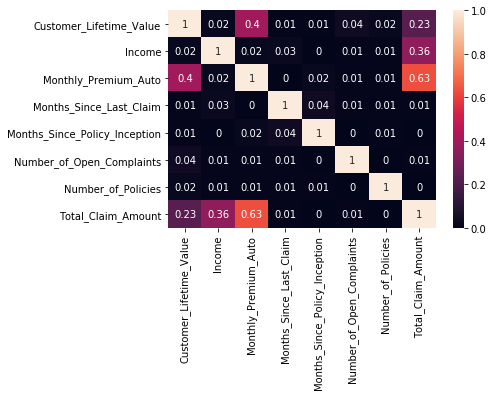

In [15]:
#let's visualize the correlations
sns.heatmap(data.corr().abs().round(2), annot=True)
plt.show()

# OLS Method

In [16]:
#after making necessary changes in numeric and object datasets
#we will combine back the datasets
data_new=data_numeric.join(data_object,how='outer')

In [17]:
variables=data_new.columns.tolist()
variables

['Customer_Lifetime_Value',
 'Income',
 'Monthly_Premium_Auto',
 'Months_Since_Last_Claim',
 'Months_Since_Policy_Inception',
 'Number_of_Open_Complaints',
 'Number_of_Policies',
 'Total_Claim_Amount',
 'State',
 'Response',
 'Coverage',
 'Education',
 'EmploymentStatus',
 'Gender',
 'Location_Code',
 'Marital_Status',
 'Policy_Type',
 'Policy',
 'Renew_Offer_Type',
 'Sales_Channel',
 'Vehicle_Class',
 'Vehicle_Size']

In [18]:
del variables[0]

In [19]:
#as there are many variables, not to input all manually let's create formula 
formula="+".join(variables)
formula='Customer_Lifetime_Value~'+formula
formula

'Customer_Lifetime_Value~Income+Monthly_Premium_Auto+Months_Since_Last_Claim+Months_Since_Policy_Inception+Number_of_Open_Complaints+Number_of_Policies+Total_Claim_Amount+State+Response+Coverage+Education+EmploymentStatus+Gender+Location_Code+Marital_Status+Policy_Type+Policy+Renew_Offer_Type+Sales_Channel+Vehicle_Class+Vehicle_Size'

Let's run the OLS model.

In [20]:
#first let's include all the explaining variables in the model
model=ols(formula=formula, data=data_new)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.170
Model:                                 OLS   Adj. R-squared:                  0.165
Method:                      Least Squares   F-statistic:                     38.65
Date:                     Fri, 15 Feb 2019   Prob (F-statistic):          2.47e-323
Time:                             14:23:58   Log-Likelihood:                -92779.
No. Observations:                     9131   AIC:                         1.857e+05
Df Residuals:                         9082   BIC:                         1.860e+05
Df Model:                               48                                         
Covariance Type:                 nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          1461.6224    903.441      1.618      0.106    -309.326    3232.571
State[T.California]                  50.4208    189.404      0.266      0.790    -320.853     421.694
State[T.Nevada]                      52.4226    261.202      0.201      0.841    -459.593     564.438
State[T.Oregon]                      95.8663    196.039      0.489      0.625    -288.415     480.147
State[T.Washington]                 174.6146    269.920      0.647      0.518    -354.490     703.719
Response[T.Yes]                    -228.7850    207.506     -1.103      0.270    -635.543     177.973
Coverage[T.Extended]                135.5695    249.235      0.544      0.586    -352.987     624.126
Coverage[T.Premium]                  67.0744    527.619      0.127      0.899    -967.178    1101.326
Education[T.College]                  6.6522    171.213      0.039      0.969    -328.964     342.269
Education[T.Doctor]                -189.2192    362.878     -0.521      0.602    -900.542     522.104
Education[T.High School or Below]   396.0814    173.390      2.284      0.022      56.197     735.966
Education[T.Master]                 164.9907    262.834      0.628      0.530    -350.223     680.204
EmploymentStatus[T.Employed]        696.0552    354.386      1.964      0.050       1.378    1390.732
EmploymentStatus[T.Medical Leave]   168.2203    436.259      0.386      0.700    -686.945    1023.386
EmploymentStatus[T.Retired]          74.5878    502.602      0.148      0.882    -910.624    1059.800
EmploymentStatus[T.Unemployed]        7.7041    357.505      0.022      0.983    -693.087     708.495
Gender[T.M]                        -147.0739    132.956     -1.106      0.269    -407.697     113.550
Location_Code[T.Suburban]           -70.7055    263.324     -0.269      0.788    -586.880     445.469
Location_Code[T.Urban]              131.4680    241.344      0.545      0.586    -341.621     604.557
Marital_Status[T.Married]          -166.6995    194.796     -0.856      0.392    -548.543     215.144
Marital_Status[T.Single]           -478.0155    225.688     -2.118      0.034    -920.415     -35.616
Policy_Type[T.Personal Auto]       -307.1667    256.663     -1.197      0.231    -810.284     195.950
Policy_Type[T.Special Auto]         166.2056    362.559      0.458      0.647    -544.491     876.902
Policy[T.Corporate L2]            -1006.8539    420.380     -2.395      0.017   -1830.893    -182.815
Policy[T.Corporate L3]             -667.5719    386.315     -1.728      0.084   -1424.836      89.692
Policy[T.Personal L1]              -159.6030    163.573     -0.976      0.329    -480.242     161.036
Policy[T.Personal L2]                -4.9589    141.780     -0.035    

# Model diagnostics

<h2> Cecking for Linearity and Equal variance</h2>

Residuals of the model will be used to test for linearity and for other assumptions as well.

1. Both linearity and equal variance can be tested by plotting residuals vs. predictions (residuals are prediction errors)
2. We will use <b>Harvey collier</b> test for linearity
3. <b>Breusch-Pagan</b> test for homoscedasticity


In [21]:
#residuals of the model
residuals=results.resid
residuals.head(10)

0     -3995.314781
1      -168.219255
3     -1639.232829
4     -3809.422193
5      2544.471465
7      -711.328284
8     18212.670038
9     -1285.176248
10     -954.802511
11     -566.101852
dtype: float64

In [23]:
#let's actually get residual values
#first, we need to get predicted values from the results of the model
#second, we should calculate the difference between predicted and true values of cons. conf. index
pred_values=results.predict()
true_values=data_new.Customer_Lifetime_Value
resid=true_values-pred_values

In [24]:
#we can see that we got the same results
resid.head(10)

0     -3995.314781
1      -168.219255
3     -1639.232829
4     -3809.422193
5      2544.471465
7      -711.328284
8     18212.670038
9     -1285.176248
10     -954.802511
11     -566.101852
Name: Customer_Lifetime_Value, dtype: float64

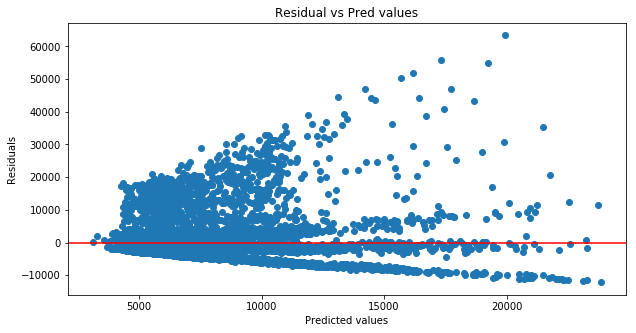

In [25]:
#lets plot predicted values vs residuals
plt.figure(figsize=(10,5))
plt.scatter(pred_values,residuals)
plt.axhline(y=0, c="red")
plt.title("Residual vs Pred values")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()

In [27]:
#Breusch-Pagan test for homoscedasticity
#The null hypothesis assumes homoskedasticity
#Small p-value shows that there is violation of homoscedasticity
sms.diagnostic.het_breuschpagan(residuals,model.exog)

(553.8521774634,
 3.9424278556030434e-86,
 12.21774995360822,
 2.323274068376767e-90)

<h2>Normality</h2>

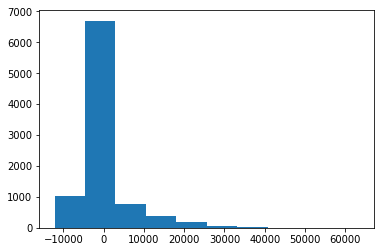

In [28]:
#visual presentation- histogram
plt.hist(residuals)
plt.show()

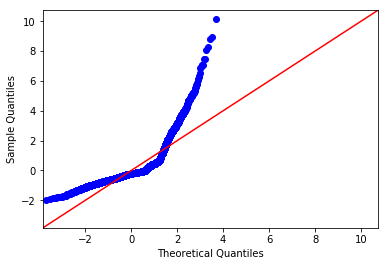

In [29]:
#QQ plot
qqplot(residuals,fit=True, line='45')
plt.show()

<b>Jarque-Bera normality test values are given in the model summary above. From where we could conclude that normality was violated. However, let's run another test of normality: Shapiro-Wilk test.</b>


In [30]:
#Shapiro-Wilk normality test. 
#The null-hypothesis of this test is that the data was drawn from a normal distribution
#We reject the Null hypothesis which means that we can state with 95% confidence that our data is not normal
stat,p = shapiro(residuals)
print(stat,p)

0.7269632816314697 0.0


C:\Users\psargsyan\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
